# Training a simple MLP using all the data provided

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
import math

import h5py
import json

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## 1. Load all files & put into dataframes

Negative training data:
- `pfam_training_data_augment.h5`
- `non_cazy_kegg.h5`

Positive training data:
- `vicreg_train_val_embeddings_noCAZOME_noLargeSeqs_combined.h5` (+ use `cazy_family_by_taxa_60.json` to pick a representative sample across all enzyme classes)


In [2]:
PUL_embeddings = []
PUL_keys = []
with h5py.File('C:\\Users\\alpha\Documents\\jennifer\\maths\\SRIM\\code\\PUL.h5', 'r') as f:
    for key in f.keys():
        PUL_embeddings.append(np.array(f[key][()]))
        PUL_keys.append(key)
        


In [3]:
PFAM_embeddings = []
PFAM_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\pfam_training_data_augment.h5', 'r') as f:
    for key in f.keys():
        PFAM_embeddings.append(f[key][()])
        PFAM_keys.append(key)

In [4]:
kegg_embeddings = []
kegg_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\non_cazy_kegg.h5', 'r') as f:
    for key in f.keys():
        kegg_embeddings.append(f[key][()])
        kegg_keys.append(key)

All of the PULs are stored in `PUL_df`, which also indicates if each protein is a CAZyme (1) or not (0):

In [5]:
#PUL file:
from Bio import SeqIO
import seaborn as sns
f_path = 'C:\\Users\\alpha\\OneDrive - University of Cambridge\\BACKUP 14-04-22\\docs\\Maths\\SRIM\\code\\PUL.faa'
PUL_array, PUL_keys2 = [], []

with open(f_path, mode='r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        identifier, description = record.id, record.description
        PUL_keys2.append(identifier)
        if 'CAZyme' in description:
            PUL_array.append(1)
        else:
            PUL_array.append(0)

PUL_array = np.array(PUL_array)
PUL_array = PUL_array.reshape(np.shape(PUL_array)[0],-1)
PUL_array_df = pd.DataFrame(PUL_array, index=PUL_keys2,columns=['cazy'])

col_label=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))]
# col_label.append('cazy')

PUL_embeddings_list=list(PUL_embeddings)
temp_df = pd.DataFrame(PUL_embeddings_list, index=PUL_keys, columns=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))])

# PUL_df = pd.DataFrame(data=np.concatenate([PUL_embeddings,PUL_array], axis=1), index=PUL_keys2, columns=col_label)
PUL_df = temp_df.join(PUL_array_df)

#indexing issue fixed

In [6]:
PUL_df

,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,...,emb1015,emb1016,emb1017,emb1018,emb1019,emb1020,emb1021,emb1022,emb1023,cazy
PUL0001_1,0.017563,0.059692,0.030075,0.007584,-0.032013,0.063904,-0.044128,-0.086609,0.033752,-0.031281,...,-0.049255,-0.006824,-0.111633,0.083191,0.030334,-0.028244,-0.008194,0.031616,0.025970,1
PUL0001_10,-0.014236,0.032715,0.034546,-0.026245,0.007820,-0.001535,-0.026840,-0.044830,-0.022736,0.003244,...,-0.020203,0.010963,-0.120483,0.041931,0.013710,0.003368,-0.005569,0.021667,-0.024216,0
PUL0001_11,-0.019104,0.034027,0.051361,0.030670,-0.013756,0.012695,-0.019608,-0.076233,0.047943,0.000046,...,-0.042297,-0.000536,-0.089661,0.064331,-0.042755,-0.018158,-0.025391,0.001602,0.011215,0
PUL0001_12,0.047211,0.002373,0.000755,0.020142,-0.008369,0.028976,-0.000050,-0.083252,0.017487,-0.002466,...,-0.031281,-0.036804,-0.075195,0.022964,0.014938,-0.035187,-0.028992,0.069641,-0.001657,0
PUL0001_13,0.024719,0.031494,0.027359,0.021515,-0.007629,0.024506,-0.014908,-0.058167,-0.014183,-0.020538,...,0.004028,0.015884,-0.064758,0.049774,-0.009315,0.007256,0.006168,0.060211,0.017761,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PUL0602_5,0.017685,0.051422,0.006428,-0.001532,0.006233,0.035370,-0.035553,-0.049744,0.028076,0.002031,...,-0.006264,-0.016479,-0.024261,0.067261,0.056061,-0.026321,0.032532,-0.009926,0.066528,1
PUL0602_6,0.009483,0.044464,0.050842,-0.036957,0.004826,-0.014664,-0.014572,-0.093689,-0.026871,0.017822,...,-0.001588,0.013908,-0.104553,0.027496,0.050049,-0.053558,0.024475,0.020248,0.038025,0
PUL0602_7,0.051819,0.009346,0.015388,-0.028381,0.013084,0.042877,-0.026932,-0.030212,0.031433,0.006268,...,-0.001817,0.013542,-0.069275,0.019424,-0.009377,-0.048309,0.009567,0.007690,-0.010933,0
PUL0602_8,0.032349,0.047760,0.041046,-0.033142,0.004124,0.082153,-0.036713,-0.099487,-0.023865,0.007652,...,-0.015564,0.004181,-0.069214,0.032410,0.000823,0.000344,-0.011467,0.043060,0.034729,0


Non-PUL negative (non-CAZyme) data is stored in `non_cazy_df`:

In [7]:
#non-cazymes:
non_cazy_embeddings = np.concatenate([PFAM_embeddings,kegg_embeddings], axis=0)
non_cazy_keys = np.concatenate([PFAM_keys, kegg_keys], axis=0)
non_cazy_df = pd.DataFrame(data=non_cazy_embeddings, index=non_cazy_keys, columns=['emb'+str(i) for i in range(len(list(non_cazy_embeddings)[0]))])
non_cazy_df = non_cazy_df.join(pd.DataFrame(data=np.zeros(np.array(non_cazy_keys).shape[0]), index=non_cazy_keys, columns=['cazy']), how='inner')


In [8]:
cazy_embeddings = []
cazy_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\vicreg_train_val_embeddings_noCAZOME_noLargeSeqs_combined.h5', 'r') as f:
    for key in f.keys():
        cazy_embeddings.append(f[key][()])
        cazy_keys.append(key)

In [9]:
print(np.shape(PUL_embeddings))
print(np.shape(non_cazy_embeddings))
print(np.shape(cazy_embeddings))

(7699, 1024)
(59673, 1024)
(244592, 1024)


## 2. Create lookup using .json file

In [10]:
family_ids = []
family_keys = []
file = open('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\cazy_family_by_taxa_60.json')

In [11]:
cazy_ids = []
cazy_families = []
file = open('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\cazy_family_by_taxa_60.json')
data = json.loads(file.read())

for key in data.keys(): #keys are IDs, values are classes
        cazy_ids.append(key)
        cazy_families.append(data.get(key))


In [12]:
# cazy_df = pd.DataFrame(data=concat , columns=['id','class'])
cazy_df_2 = pd.DataFrame(data=cazy_families, index=cazy_ids , columns=['class'])

Create dataframe of cazymes with extra columnns containing embeddings, then inner join with cazy_df_2 (intersect dataframes at indices)

In [13]:
cazy_df_1 = pd.DataFrame(data=cazy_embeddings, index=cazy_keys, columns=['emb'+str(i) for i in range(len(list(cazy_embeddings)[0]))])

# long (~12 min)

In [14]:
cazy_df = cazy_df_2.join(cazy_df_1, how='inner')
print(cazy_df)

             class      emb0      emb1      emb2      emb3      emb4  \
AZS17016.1  GH13_2  0.049500  0.037415 -0.038025  0.031235  0.017197   
AVO05213.1    GH32 -0.014870  0.036865  0.009872 -0.011703  0.015808   
QPG94344.1    GT61  0.016739 -0.028412  0.026016  0.017227  0.013565   
APD47233.1     GT4  0.015976 -0.009315 -0.032532  0.033173  0.011223   
ANU32067.1     GT4  0.010872 -0.021881 -0.008972 -0.013237  0.000924   
...            ...       ...       ...       ...       ...       ...   
QMI07227.1    GT83 -0.008034 -0.009453  0.029785  0.033478  0.024063   
UMA63307.1     GT2  0.019272 -0.044830  0.024490  0.026031  0.026672   
UPW01296.1     GT4  0.055878 -0.059723 -0.039551 -0.001044  0.057983   
ULL17023.1    GH43  0.013275  0.033997  0.013687  0.021133  0.018799   
USF23742.1     GT9  0.022705 -0.043182 -0.023972  0.007046 -0.025818   

                emb5      emb6      emb7      emb8  ...   emb1014   emb1015  \
AZS17016.1  0.031616 -0.019043 -0.046234  0.007179  ... 

In [15]:
cazy_GH_df = cazy_df[cazy_df['class'].str.contains('GH')]
cazy_GT_df = cazy_df[cazy_df['class'].str.contains('GT')]
cazy_PL_df = cazy_df[cazy_df['class'].str.contains('PL')]
cazy_CE_df = cazy_df[cazy_df['class'].str.contains('CE')]

allclasses=['GH', 'GT', 'PL', 'CE']
cazy_other_df = cazy_df[cazy_df['class'].str.contains('|'.join(allclasses))]

#then use pd.DataFrame.sample to take random sample of items across axis 0


size of first four dataframes add up to 232736; so in fact no other classes to account for

Sample proportionally to size of each class:

In [16]:
x=5000/232736
new_cazy_GH_df = cazy_GH_df.sample(frac=x, axis=0)
new_cazy_GT_df = cazy_GT_df.sample(frac=x, axis=0)
new_cazy_PL_df = cazy_PL_df.sample(frac=x, axis=0)
new_cazy_CE_df = cazy_CE_df.sample(frac=x, axis=0)

Concatenate into one DataFrame:

Positive training data is stored in `cazy_train_df` (5001 embeddings):

In [17]:
cazy_train_df = pd.concat([new_cazy_GH_df, new_cazy_GT_df, new_cazy_PL_df, new_cazy_CE_df], axis=0)
cazy_train_df = cazy_train_df.join(pd.DataFrame(data=np.ones(np.array(cazy_ids).shape[0]), index=cazy_ids, columns=['cazy']), how='inner')

In [18]:
cazy_train_df

,class,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,...,emb1015,emb1016,emb1017,emb1018,emb1019,emb1020,emb1021,emb1022,emb1023,cazy
QPC84684.1,GH78,0.016434,0.020996,0.010185,-0.004520,-0.002573,0.022385,-0.025391,-0.087402,-0.003696,...,-0.004845,0.007828,-0.052094,0.025772,0.033905,0.001213,0.017990,0.041046,0.002014,1.0
ATO55907.1,GH25,-0.015541,0.004791,0.003641,0.040192,-0.008339,-0.031921,-0.038879,-0.085327,-0.020142,...,-0.054749,-0.040405,-0.038757,0.045563,0.030258,-0.010086,0.047241,-0.052155,0.006237,1.0
UIP58386.1,GH78,-0.000752,-0.038025,0.023712,-0.011497,0.001517,0.024445,-0.012955,-0.070496,-0.000738,...,-0.034729,0.011955,-0.034576,0.007610,0.017227,-0.004364,0.009430,0.060394,-0.011192,1.0
BBH16690.1,GH13_31,0.034088,0.037079,-0.001828,-0.008621,-0.001671,0.047028,-0.061798,-0.077820,-0.022659,...,-0.023575,-0.000435,-0.059937,0.015625,-0.013550,-0.012604,-0.050293,0.051605,0.042236,1.0
CBA32915.1,GH63,0.045410,0.006805,0.050629,-0.041229,0.046570,-0.075317,0.030457,-0.113525,0.009491,...,-0.006058,0.002708,-0.064148,0.151245,-0.022156,-0.075684,-0.016235,0.039734,0.057281,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QGW65371.1,CE4,0.012901,-0.023987,0.004219,0.058319,0.013100,0.042236,-0.004894,-0.064392,0.000936,...,-0.045868,0.004707,-0.005524,-0.003883,0.048767,0.016068,0.001952,0.022064,0.079346,1.0
BBB47795.1,CE9,0.022385,0.043793,0.039673,0.004883,-0.057648,0.053528,-0.039856,-0.094421,-0.032898,...,-0.066528,-0.004166,-0.098450,0.023987,-0.006149,-0.023438,-0.036133,0.039795,0.041504,1.0
UGQ12528.1,CE9,0.009865,0.021515,0.025146,-0.013252,-0.033569,0.008659,-0.014488,-0.076721,0.024826,...,-0.053619,-0.025909,-0.083740,-0.046753,-0.024216,-0.000406,-0.035004,0.002735,-0.024826,1.0
QDT00392.1,CE6,0.038483,0.060425,0.015427,-0.049988,-0.047943,0.061951,-0.073364,-0.090149,0.001916,...,0.004028,0.026443,-0.050110,-0.034607,0.047302,-0.000613,-0.013847,0.015625,0.003159,1.0


## 3. Create training dataframe + train a simple MLP


Negative training data is stored in `non_cazy_df`:

In [19]:
non_cazy_train_df = non_cazy_df.sample(n=10000, axis=0)

### (a) Using PUL file entirely for inference; `train_df` for training:


Concatenate non-cazy and cazy training dataframes (size = 10000 + 5001):

In [20]:
train_df = pd.concat([cazy_train_df, non_cazy_train_df], axis=0).iloc[:,1:] #removes 'class' column

In [21]:
X_train, y_train = np.array(train_df.iloc[:,:-1]), np.array(train_df.iloc[:,-1:])
X_test, y_test = np.array(PUL_df.iloc[:,:-1]), np.array(PUL_df.iloc[:,-1:])

MLP: 2 layers, each with 100 neurons

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(7,2,4),
                     activation = 'logistic',
                     solver = 'adam',
                     verbose = True).fit(X_train,y_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.66621192
Iteration 2, loss = 0.64645933
Iteration 3, loss = 0.63729106
Iteration 4, loss = 0.62853588
Iteration 5, loss = 0.61743365
Iteration 6, loss = 0.60316161
Iteration 7, loss = 0.58436629
Iteration 8, loss = 0.55947048
Iteration 9, loss = 0.52769701
Iteration 10, loss = 0.48985019
Iteration 11, loss = 0.44816615
Iteration 12, loss = 0.40544248
Iteration 13, loss = 0.36490650
Iteration 14, loss = 0.32761950
Iteration 15, loss = 0.29417611
Iteration 16, loss = 0.26458403
Iteration 17, loss = 0.23867258
Iteration 18, loss = 0.21600138
Iteration 19, loss = 0.19615313
Iteration 20, loss = 0.17873264
Iteration 21, loss = 0.16371186
Iteration 22, loss = 0.15071952
Iteration 23, loss = 0.13933400
Iteration 24, loss = 0.12922848
Iteration 25, loss = 0.12032861
Iteration 26, loss = 0.11237258
Iteration 27, loss = 0.10517639
Iteration 28, loss = 0.09884723
Iteration 29, loss = 0.09307522
Iteration 30, loss = 0.08792307
Iteration 31, loss = 0.08328090
Iteration 32, los

In [23]:
y_pred = mlp.predict(X_test)

In [24]:
print(accuracy_score(y_test,y_pred))
#confusion matrix
mat = confusion_matrix(y_test, y_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

0.7112612027536044
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             3847         2187
Cazyme                   36         1629



- Using PUL file entirely for inference produces poor results, worse than trivial classifier (78.4%) - why??
- positive prediction is much better than negative
- Increasing number of layers gives better results (10 layers: 75.1%) for (a) but worse for (c) (10 layers: 80.8%) (why)

**2 layers:**
- 74.7% (100,100); 76.2% (10,10)

**3 layers:**
- 76.2% (100,100,100)

**4 layers:**
 - relu: 72.6% (10,10,10,10)





Using RandomizedSearchCV for hyperparameter tuning:


In [32]:
templist = []
for i in range(2,10):
    for j in range(2,10):
        for k in range(2,10):
            templist.append((i,j,k))

distributions = {'hidden_layer_sizes':templist,
              'activation':('logistic','relu')
              }

#layer norm
# regularise weights


clf = RandomizedSearchCV(estimator=mlp, param_distributions=distributions, cv=5, verbose=1) #, refit=True)

Best parameters: 'hidden_layer_sizes': (7, 2, 4), 'activation': 'logistic'

In [33]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.65141205
Iteration 2, loss = 0.64759013
Iteration 3, loss = 0.64456793
Iteration 4, loss = 0.64223068
Iteration 5, loss = 0.64046713
Iteration 6, loss = 0.63918862
Iteration 7, loss = 0.63826718
Iteration 8, loss = 0.63767913
Iteration 9, loss = 0.63724264
Iteration 10, loss = 0.63695860
Iteration 11, loss = 0.63679267
Iteration 12, loss = 0.63667419
Iteration 13, loss = 0.63660843
Iteration 14, loss = 0.63657262
Iteration 15, loss = 0.63655618
Iteration 16, loss = 0.63653473
Iteration 17, loss = 0.63655096
Iteration 18, loss = 0.63652591
Iteration 19, loss = 0.63652641
Iteration 20, loss = 0.63652360
Iteration 21, loss = 0.63653672
Iteration 22, loss = 0.63652034
Iteration 23, loss = 0.63653035
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64220063
Iteration 2, loss = 0.51168219
Iteration 3, loss = 0.41325286
Iteration 4, loss = 0.33292991
Iteration 5, loss = 0.27170699
Iteration 6, loss = 0.22433698
Iteration 7, loss = 0.18762370
Iteration 8, loss = 0.15899564
Iteration 9, loss = 0.13830963
Iteration 10, loss = 0.12051187
Iteration 11, loss = 0.10627104
Iteration 12, loss = 0.09456215
Iteration 13, loss = 0.08496506
Iteration 14, loss = 0.07781330
Iteration 15, loss = 0.07166806
Iteration 16, loss = 0.06655945
Iteration 17, loss = 0.06186687
Iteration 18, loss = 0.05771017
Iteration 19, loss = 0.05411061
Iteration 20, loss = 0.05070997
Iteration 21, loss = 0.04777720
Iteration 22, loss = 0.04516428
Iteration 23, loss = 0.04257904
Iteration 24, loss = 0.04032902
Iteration 25, loss = 0.03801184
Iteration 26, loss = 0.03619472
Iteration 27, loss = 0.03450025
Iteration 28, loss = 0.03303206
Iteration 29, loss = 0.03150475
Iteration 30, loss = 0.03028433
Iteration 31, loss = 0.02904482
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.01842592
Iteration 2, loss = 0.95115376
Iteration 3, loss = 0.89996187
Iteration 4, loss = 0.85880705
Iteration 5, loss = 0.79134211
Iteration 6, loss = 0.55738655
Iteration 7, loss = 0.34344252
Iteration 8, loss = 0.25377782
Iteration 9, loss = 0.21059281
Iteration 10, loss = 0.17675993
Iteration 11, loss = 0.12884461
Iteration 12, loss = 0.08119025
Iteration 13, loss = 0.06418945
Iteration 14, loss = 0.05641323
Iteration 15, loss = 0.05151560
Iteration 16, loss = 0.04746650
Iteration 17, loss = 0.04433022
Iteration 18, loss = 0.04168728
Iteration 19, loss = 0.03908192
Iteration 20, loss = 0.03682507
Iteration 21, loss = 0.03503454
Iteration 22, loss = 0.03323998
Iteration 23, loss = 0.03162002
Iteration 24, loss = 0.03015363
Iteration 25, loss = 0.02895134
Iteration 26, loss = 0.02768941
Iteration 27, loss = 0.02659825
Iteration 28, loss = 0.02555460
Iteration 29, loss = 0.02566666
Iteration 30, loss = 0.02403692
Iteration 31, loss = 0.02307360
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.92261489
Iteration 2, loss = 0.90108939
Iteration 3, loss = 0.88114728
Iteration 4, loss = 0.86156104
Iteration 5, loss = 0.84309219
Iteration 6, loss = 0.82642762
Iteration 7, loss = 0.81091565
Iteration 8, loss = 0.79567695
Iteration 9, loss = 0.78132088
Iteration 10, loss = 0.76865404
Iteration 11, loss = 0.75630395
Iteration 12, loss = 0.74474687
Iteration 13, loss = 0.73469816
Iteration 14, loss = 0.72488166
Iteration 15, loss = 0.71576051
Iteration 16, loss = 0.70739399
Iteration 17, loss = 0.70029672
Iteration 18, loss = 0.69332613
Iteration 19, loss = 0.68691324
Iteration 20, loss = 0.68106805
Iteration 21, loss = 0.67578882
Iteration 22, loss = 0.67102546
Iteration 23, loss = 0.66715851
Iteration 24, loss = 0.66374386
Iteration 25, loss = 0.66027972
Iteration 26, loss = 0.65747403
Iteration 27, loss = 0.65505536
Iteration 28, loss = 0.65252014
Iteration 29, loss = 0.65021629
Iteration 30, loss = 0.64821542
Iteration 31, loss = 0.64643376
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64259515
Iteration 2, loss = 0.63865855
Iteration 3, loss = 0.63704445
Iteration 4, loss = 0.63665087
Iteration 5, loss = 0.63656212
Iteration 6, loss = 0.63658195
Iteration 7, loss = 0.63661663
Iteration 8, loss = 0.63658232
Iteration 9, loss = 0.63661262
Iteration 10, loss = 0.63654256
Iteration 11, loss = 0.63660916
Iteration 12, loss = 0.63659821
Iteration 13, loss = 0.63657988
Iteration 14, loss = 0.63657719
Iteration 15, loss = 0.63657201
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.08762343
Iteration 2, loss = 1.02014983
Iteration 3, loss = 0.99370100
Iteration 4, loss = 0.96844067
Iteration 5, loss = 0.94304983
Iteration 6, loss = 0.91513547
Iteration 7, loss = 0.87029633
Iteration 8, loss = 0.80168508
Iteration 9, loss = 0.75603726
Iteration 10, loss = 0.72346342
Iteration 11, loss = 0.69426991
Iteration 12, loss = 0.66726029
Iteration 13, loss = 0.64195324
Iteration 14, loss = 0.61790186
Iteration 15, loss = 0.59469674
Iteration 16, loss = 0.57285885
Iteration 17, loss = 0.55156697
Iteration 18, loss = 0.53151945
Iteration 19, loss = 0.51214581
Iteration 20, loss = 0.49346182
Iteration 21, loss = 0.47555909
Iteration 22, loss = 0.45836108
Iteration 23, loss = 0.44208013
Iteration 24, loss = 0.42608113
Iteration 25, loss = 0.41095802
Iteration 26, loss = 0.39617568
Iteration 27, loss = 0.38203149
Iteration 28, loss = 0.36863715
Iteration 29, loss = 0.35568108
Iteration 30, loss = 0.34323979
Iteration 31, loss = 0.33114488
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55238146
Iteration 2, loss = 0.36775048
Iteration 3, loss = 0.28566574
Iteration 4, loss = 0.25652423
Iteration 5, loss = 0.23377544
Iteration 6, loss = 0.21624299
Iteration 7, loss = 0.20126791
Iteration 8, loss = 0.18871550
Iteration 9, loss = 0.17893619
Iteration 10, loss = 0.17023435
Iteration 11, loss = 0.16165652
Iteration 12, loss = 0.15420168
Iteration 13, loss = 0.14774292
Iteration 14, loss = 0.14098010
Iteration 15, loss = 0.13490805
Iteration 16, loss = 0.12920641
Iteration 17, loss = 0.12425224
Iteration 18, loss = 0.11887665
Iteration 19, loss = 0.11415091
Iteration 20, loss = 0.10967735
Iteration 21, loss = 0.10540577
Iteration 22, loss = 0.10157748
Iteration 23, loss = 0.09771002
Iteration 24, loss = 0.09779872
Iteration 25, loss = 0.09161163
Iteration 26, loss = 0.08811111
Iteration 27, loss = 0.08515591
Iteration 28, loss = 0.08210607
Iteration 29, loss = 0.07964216
Iteration 30, loss = 0.07683856
Iteration 31, loss = 0.07454398
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.58761509
Iteration 2, loss = 0.39790111
Iteration 3, loss = 0.18347359
Iteration 4, loss = 0.08753247
Iteration 5, loss = 0.06374479
Iteration 6, loss = 0.05320473
Iteration 7, loss = 0.04616068
Iteration 8, loss = 0.04193124
Iteration 9, loss = 0.03804704
Iteration 10, loss = 0.03504639
Iteration 11, loss = 0.04361953
Iteration 12, loss = 0.03378648
Iteration 13, loss = 0.03230719
Iteration 14, loss = 0.03114977
Iteration 15, loss = 0.03039827
Iteration 16, loss = 0.02972281
Iteration 17, loss = 0.02857217
Iteration 18, loss = 0.02786944
Iteration 19, loss = 0.02738865
Iteration 20, loss = 0.02655726
Iteration 21, loss = 0.02599433
Iteration 22, loss = 0.02538521
Iteration 23, loss = 0.02468649
Iteration 24, loss = 0.02406765
Iteration 25, loss = 0.02346570
Iteration 26, loss = 0.02294520
Iteration 27, loss = 0.02230598
Iteration 28, loss = 0.02187652
Iteration 29, loss = 0.02129930
Iteration 30, loss = 0.02079084
Iteration 31, loss = 0.02021918
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.52283145
Iteration 2, loss = 0.34873590
Iteration 3, loss = 0.27118852
Iteration 4, loss = 0.22361780
Iteration 5, loss = 0.18783670
Iteration 6, loss = 0.16003203
Iteration 7, loss = 0.12956169
Iteration 8, loss = 0.07134230
Iteration 9, loss = 0.04738794
Iteration 10, loss = 0.03590988
Iteration 11, loss = 0.03078901
Iteration 12, loss = 0.02784030
Iteration 13, loss = 0.02523943
Iteration 14, loss = 0.02230883
Iteration 15, loss = 0.02118015
Iteration 16, loss = 0.01980335
Iteration 17, loss = 0.01799175
Iteration 18, loss = 0.01711538
Iteration 19, loss = 0.01606957
Iteration 20, loss = 0.01519832
Iteration 21, loss = 0.01976934
Iteration 22, loss = 0.01447521
Iteration 23, loss = 0.01356579
Iteration 24, loss = 0.01229466
Iteration 25, loss = 0.01193905
Iteration 26, loss = 0.01129992
Iteration 27, loss = 0.01495875
Iteration 28, loss = 0.01073109
Iteration 29, loss = 0.01026737
Iteration 30, loss = 0.00950195
Iteration 31, loss = 0.00908668
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.83940263
Iteration 2, loss = 0.82087893
Iteration 3, loss = 0.80380314
Iteration 4, loss = 0.78797664
Iteration 5, loss = 0.77394160
Iteration 6, loss = 0.76034568
Iteration 7, loss = 0.74830986
Iteration 8, loss = 0.73670743
Iteration 9, loss = 0.72657172
Iteration 10, loss = 0.71673466
Iteration 11, loss = 0.70769529
Iteration 12, loss = 0.69942895
Iteration 13, loss = 0.69197870
Iteration 14, loss = 0.68522811
Iteration 15, loss = 0.67915354
Iteration 16, loss = 0.67371197
Iteration 17, loss = 0.66930241
Iteration 18, loss = 0.66544317
Iteration 19, loss = 0.66153677
Iteration 20, loss = 0.65801464
Iteration 21, loss = 0.65488614
Iteration 22, loss = 0.65253459
Iteration 23, loss = 0.65015464
Iteration 24, loss = 0.64834521
Iteration 25, loss = 0.64650387
Iteration 26, loss = 0.64484648
Iteration 27, loss = 0.64371541
Iteration 28, loss = 0.64277497
Iteration 29, loss = 0.64169482
Iteration 30, loss = 0.64074129
Iteration 31, loss = 0.63993972
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.51386175
Iteration 2, loss = 0.28103041
Iteration 3, loss = 0.16615958
Iteration 4, loss = 0.10245178
Iteration 5, loss = 0.07200034
Iteration 6, loss = 0.05466461
Iteration 7, loss = 0.04449872
Iteration 8, loss = 0.03861624
Iteration 9, loss = 0.03391841
Iteration 10, loss = 0.03064939
Iteration 11, loss = 0.02811427
Iteration 12, loss = 0.02552745
Iteration 13, loss = 0.02374271
Iteration 14, loss = 0.02258564
Iteration 15, loss = 0.02076007
Iteration 16, loss = 0.01957438
Iteration 17, loss = 0.01894481
Iteration 18, loss = 0.01746410
Iteration 19, loss = 0.01668484
Iteration 20, loss = 0.01532881
Iteration 21, loss = 0.01489876
Iteration 22, loss = 0.01397999
Iteration 23, loss = 0.01300619
Iteration 24, loss = 0.01214894
Iteration 25, loss = 0.01147133
Iteration 26, loss = 0.01069253
Iteration 27, loss = 0.00978798
Iteration 28, loss = 0.00926775
Iteration 29, loss = 0.00849521
Iteration 30, loss = 0.00832797
Iteration 31, loss = 0.00730209
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.60182394
Iteration 2, loss = 0.44504653
Iteration 3, loss = 0.28234883
Iteration 4, loss = 0.15419015
Iteration 5, loss = 0.09004023
Iteration 6, loss = 0.07231300
Iteration 7, loss = 0.05551425
Iteration 8, loss = 0.04762261
Iteration 9, loss = 0.04303565
Iteration 10, loss = 0.04024999
Iteration 11, loss = 0.03771735
Iteration 12, loss = 0.03485999
Iteration 13, loss = 0.03258730
Iteration 14, loss = 0.03086835
Iteration 15, loss = 0.02904678
Iteration 16, loss = 0.02763752
Iteration 17, loss = 0.02622275
Iteration 18, loss = 0.02499261
Iteration 19, loss = 0.02393258
Iteration 20, loss = 0.02300823
Iteration 21, loss = 0.02195852
Iteration 22, loss = 0.02097466
Iteration 23, loss = 0.02014799
Iteration 24, loss = 0.01955958
Iteration 25, loss = 0.01842364
Iteration 26, loss = 0.01752488
Iteration 27, loss = 0.01681891
Iteration 28, loss = 0.01624817
Iteration 29, loss = 0.01535639
Iteration 30, loss = 0.01461237
Iteration 31, loss = 0.01400858
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.61653068
Iteration 2, loss = 0.46859429
Iteration 3, loss = 0.28462050
Iteration 4, loss = 0.16253944
Iteration 5, loss = 0.09826817
Iteration 6, loss = 0.07166271
Iteration 7, loss = 0.05940698
Iteration 8, loss = 0.05182573
Iteration 9, loss = 0.04712044
Iteration 10, loss = 0.04273852
Iteration 11, loss = 0.03927169
Iteration 12, loss = 0.03639351
Iteration 13, loss = 0.03399559
Iteration 14, loss = 0.03218040
Iteration 15, loss = 0.04101768
Iteration 16, loss = 0.03077436
Iteration 17, loss = 0.02977864
Iteration 18, loss = 0.02883406
Iteration 19, loss = 0.02805022
Iteration 20, loss = 0.02728838
Iteration 21, loss = 0.02667949
Iteration 22, loss = 0.02606187
Iteration 23, loss = 0.02543674
Iteration 24, loss = 0.02478318
Iteration 25, loss = 0.02419012
Iteration 26, loss = 0.02364135
Iteration 27, loss = 0.02310903
Iteration 28, loss = 0.02260143
Iteration 29, loss = 0.02217533
Iteration 30, loss = 0.02169733
Iteration 31, loss = 0.02116513
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.54947347
Iteration 2, loss = 0.33008610
Iteration 3, loss = 0.16460050
Iteration 4, loss = 0.08790589
Iteration 5, loss = 0.06016741
Iteration 6, loss = 0.04801203
Iteration 7, loss = 0.04108026
Iteration 8, loss = 0.03649383
Iteration 9, loss = 0.03297340
Iteration 10, loss = 0.03015097
Iteration 11, loss = 0.02762367
Iteration 12, loss = 0.02569695
Iteration 13, loss = 0.02448163
Iteration 14, loss = 0.02291326
Iteration 15, loss = 0.02153485
Iteration 16, loss = 0.02040710
Iteration 17, loss = 0.01938689
Iteration 18, loss = 0.01853746
Iteration 19, loss = 0.01746773
Iteration 20, loss = 0.01654534
Iteration 21, loss = 0.01594091
Iteration 22, loss = 0.01522619
Iteration 23, loss = 0.01459064
Iteration 24, loss = 0.01412440
Iteration 25, loss = 0.01320552
Iteration 26, loss = 0.01274724
Iteration 27, loss = 0.01217054
Iteration 28, loss = 0.01162367
Iteration 29, loss = 0.01087071
Iteration 30, loss = 0.01061035
Iteration 31, loss = 0.01069191
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.53187331
Iteration 2, loss = 0.24357661
Iteration 3, loss = 0.11829479
Iteration 4, loss = 0.07532501
Iteration 5, loss = 0.05652067
Iteration 6, loss = 0.04625903
Iteration 7, loss = 0.03976546
Iteration 8, loss = 0.03652505
Iteration 9, loss = 0.03242228
Iteration 10, loss = 0.02969840
Iteration 11, loss = 0.02751290
Iteration 12, loss = 0.02566070
Iteration 13, loss = 0.02405180
Iteration 14, loss = 0.02261242
Iteration 15, loss = 0.02154999
Iteration 16, loss = 0.02028900
Iteration 17, loss = 0.02120138
Iteration 18, loss = 0.01858585
Iteration 19, loss = 0.01765382
Iteration 20, loss = 0.01675257
Iteration 21, loss = 0.02272953
Iteration 22, loss = 0.01664313
Iteration 23, loss = 0.01583099
Iteration 24, loss = 0.03885601
Iteration 25, loss = 0.01751342
Iteration 26, loss = 0.01588052
Iteration 27, loss = 0.01508018
Iteration 28, loss = 0.01439713
Iteration 29, loss = 0.01388216
Iteration 30, loss = 0.01345374
Iteration 31, loss = 0.01313105
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63661101
Iteration 2, loss = 0.63365660
Iteration 3, loss = 0.62581612
Iteration 4, loss = 0.60577731
Iteration 5, loss = 0.56422121
Iteration 6, loss = 0.49610180
Iteration 7, loss = 0.41176008
Iteration 8, loss = 0.33022437
Iteration 9, loss = 0.26311187
Iteration 10, loss = 0.21255808
Iteration 11, loss = 0.17543185
Iteration 12, loss = 0.14821554
Iteration 13, loss = 0.12781958
Iteration 14, loss = 0.11239138
Iteration 15, loss = 0.10017492
Iteration 16, loss = 0.09060258
Iteration 17, loss = 0.08276238
Iteration 18, loss = 0.07631510
Iteration 19, loss = 0.07084335
Iteration 20, loss = 0.06621803
Iteration 21, loss = 0.06238851
Iteration 22, loss = 0.05879881
Iteration 23, loss = 0.05575963
Iteration 24, loss = 0.05303243
Iteration 25, loss = 0.05059585
Iteration 26, loss = 0.04835533
Iteration 27, loss = 0.04643439
Iteration 28, loss = 0.04457967
Iteration 29, loss = 0.04291046
Iteration 30, loss = 0.04146598
Iteration 31, loss = 0.03996653
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.74322219
Iteration 2, loss = 0.68194154
Iteration 3, loss = 0.64957355
Iteration 4, loss = 0.63084420
Iteration 5, loss = 0.61441871
Iteration 6, loss = 0.59213226
Iteration 7, loss = 0.56079369
Iteration 8, loss = 0.52018612
Iteration 9, loss = 0.47036546
Iteration 10, loss = 0.41299241
Iteration 11, loss = 0.35292913
Iteration 12, loss = 0.29626905
Iteration 13, loss = 0.24706182
Iteration 14, loss = 0.20802473
Iteration 15, loss = 0.17738302
Iteration 16, loss = 0.15339731
Iteration 17, loss = 0.13464631
Iteration 18, loss = 0.11966302
Iteration 19, loss = 0.10757201
Iteration 20, loss = 0.09781414
Iteration 21, loss = 0.08966848
Iteration 22, loss = 0.08295660
Iteration 23, loss = 0.07720112
Iteration 24, loss = 0.07230846
Iteration 25, loss = 0.07087333
Iteration 26, loss = 0.06557469
Iteration 27, loss = 0.06256480
Iteration 28, loss = 0.06007140
Iteration 29, loss = 0.05783301
Iteration 30, loss = 0.05579043
Iteration 31, loss = 0.05403964
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.79104171
Iteration 2, loss = 0.70058806
Iteration 3, loss = 0.65729383
Iteration 4, loss = 0.63607352
Iteration 5, loss = 0.62104989
Iteration 6, loss = 0.60827484
Iteration 7, loss = 0.59337603
Iteration 8, loss = 0.57355969
Iteration 9, loss = 0.54869466
Iteration 10, loss = 0.51655813
Iteration 11, loss = 0.47489344
Iteration 12, loss = 0.42488551
Iteration 13, loss = 0.37084472
Iteration 14, loss = 0.31709671
Iteration 15, loss = 0.26910246
Iteration 16, loss = 0.22914018
Iteration 17, loss = 0.19657278
Iteration 18, loss = 0.17017965
Iteration 19, loss = 0.14900220
Iteration 20, loss = 0.13206435
Iteration 21, loss = 0.11861322
Iteration 22, loss = 0.10742455
Iteration 23, loss = 0.09826353
Iteration 24, loss = 0.09066291
Iteration 25, loss = 0.08416698
Iteration 26, loss = 0.07856305
Iteration 27, loss = 0.07380896
Iteration 28, loss = 0.06961331
Iteration 29, loss = 0.06603091
Iteration 30, loss = 0.06278708
Iteration 31, loss = 0.05981257
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.72832541
Iteration 2, loss = 0.67172300
Iteration 3, loss = 0.64601759
Iteration 4, loss = 0.63359028
Iteration 5, loss = 0.62283023
Iteration 6, loss = 0.60618512
Iteration 7, loss = 0.57867572
Iteration 8, loss = 0.53844134
Iteration 9, loss = 0.48384907
Iteration 10, loss = 0.41990882
Iteration 11, loss = 0.35666485
Iteration 12, loss = 0.29958522
Iteration 13, loss = 0.25269835
Iteration 14, loss = 0.21598234
Iteration 15, loss = 0.18658243
Iteration 16, loss = 0.16373506
Iteration 17, loss = 0.14535368
Iteration 18, loss = 0.13068749
Iteration 19, loss = 0.11853772
Iteration 20, loss = 0.10852413
Iteration 21, loss = 0.09987244
Iteration 22, loss = 0.09254595
Iteration 23, loss = 0.08619753
Iteration 24, loss = 0.08064145
Iteration 25, loss = 0.07573522
Iteration 26, loss = 0.07138809
Iteration 27, loss = 0.06749262
Iteration 28, loss = 0.06409191
Iteration 29, loss = 0.06094853
Iteration 30, loss = 0.05810294
Iteration 31, loss = 0.05553166
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.71940903
Iteration 2, loss = 0.66069191
Iteration 3, loss = 0.63657855
Iteration 4, loss = 0.62506481
Iteration 5, loss = 0.61056494
Iteration 6, loss = 0.59077160
Iteration 7, loss = 0.56432193
Iteration 8, loss = 0.53198621
Iteration 9, loss = 0.49442563
Iteration 10, loss = 0.45367160
Iteration 11, loss = 0.40996299
Iteration 12, loss = 0.36639087
Iteration 13, loss = 0.32549686
Iteration 14, loss = 0.28740247
Iteration 15, loss = 0.25334542
Iteration 16, loss = 0.22413194
Iteration 17, loss = 0.19932036
Iteration 18, loss = 0.17823309
Iteration 19, loss = 0.16052451
Iteration 20, loss = 0.14500580
Iteration 21, loss = 0.13185808
Iteration 22, loss = 0.12057957
Iteration 23, loss = 0.11073054
Iteration 24, loss = 0.10222521
Iteration 25, loss = 0.09471603
Iteration 26, loss = 0.08815672
Iteration 27, loss = 0.08244693
Iteration 28, loss = 0.07736420
Iteration 29, loss = 0.07279093
Iteration 30, loss = 0.06865165
Iteration 31, loss = 0.06492843
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63614352
Iteration 2, loss = 0.62786990
Iteration 3, loss = 0.59963640
Iteration 4, loss = 0.52965488
Iteration 5, loss = 0.42322066
Iteration 6, loss = 0.31738208
Iteration 7, loss = 0.23751293
Iteration 8, loss = 0.18354350
Iteration 9, loss = 0.14750738
Iteration 10, loss = 0.12305403
Iteration 11, loss = 0.10555503
Iteration 12, loss = 0.09281657
Iteration 13, loss = 0.08287566
Iteration 14, loss = 0.07527714
Iteration 15, loss = 0.06903080
Iteration 16, loss = 0.06390022
Iteration 17, loss = 0.05952308
Iteration 18, loss = 0.05575576
Iteration 19, loss = 0.05252138
Iteration 20, loss = 0.04977817
Iteration 21, loss = 0.04731071
Iteration 22, loss = 0.04508532
Iteration 23, loss = 0.04295788
Iteration 24, loss = 0.04119568
Iteration 25, loss = 0.03983623
Iteration 26, loss = 0.03813357
Iteration 27, loss = 0.03673799
Iteration 28, loss = 0.03549057
Iteration 29, loss = 0.03430315
Iteration 30, loss = 0.03329733
Iteration 31, loss = 0.03237935
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63734754
Iteration 2, loss = 0.63179311
Iteration 3, loss = 0.62227354
Iteration 4, loss = 0.59878914
Iteration 5, loss = 0.55194541
Iteration 6, loss = 0.48246158
Iteration 7, loss = 0.39802467
Iteration 8, loss = 0.31569809
Iteration 9, loss = 0.25052939
Iteration 10, loss = 0.20145823
Iteration 11, loss = 0.16635567
Iteration 12, loss = 0.14123373
Iteration 13, loss = 0.12245284
Iteration 14, loss = 0.10818258
Iteration 15, loss = 0.09665158
Iteration 16, loss = 0.08764566
Iteration 17, loss = 0.08009755
Iteration 18, loss = 0.07527784
Iteration 19, loss = 0.07056557
Iteration 20, loss = 0.06637025
Iteration 21, loss = 0.06240217
Iteration 22, loss = 0.05890684
Iteration 23, loss = 0.05593483
Iteration 24, loss = 0.05328965
Iteration 25, loss = 0.05070754
Iteration 26, loss = 0.04857965
Iteration 27, loss = 0.04652659
Iteration 28, loss = 0.04471875
Iteration 29, loss = 0.04297625
Iteration 30, loss = 0.04145666
Iteration 31, loss = 0.04001561
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.70937578
Iteration 2, loss = 0.65624097
Iteration 3, loss = 0.63405441
Iteration 4, loss = 0.62126409
Iteration 5, loss = 0.60303461
Iteration 6, loss = 0.57075460
Iteration 7, loss = 0.51889604
Iteration 8, loss = 0.45151061
Iteration 9, loss = 0.37792403
Iteration 10, loss = 0.30986276
Iteration 11, loss = 0.25475914
Iteration 12, loss = 0.21307072
Iteration 13, loss = 0.18135084
Iteration 14, loss = 0.15730598
Iteration 15, loss = 0.13864887
Iteration 16, loss = 0.12364805
Iteration 17, loss = 0.11177699
Iteration 18, loss = 0.10234678
Iteration 19, loss = 0.09405156
Iteration 20, loss = 0.08738016
Iteration 21, loss = 0.08187561
Iteration 22, loss = 0.07682405
Iteration 23, loss = 0.07235237
Iteration 24, loss = 0.06868418
Iteration 25, loss = 0.06527632
Iteration 26, loss = 0.06217710
Iteration 27, loss = 0.05940321
Iteration 28, loss = 0.05669822
Iteration 29, loss = 0.05438225
Iteration 30, loss = 0.05185405
Iteration 31, loss = 0.04981706
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64930729
Iteration 2, loss = 0.63464455
Iteration 3, loss = 0.62746709
Iteration 4, loss = 0.61469213
Iteration 5, loss = 0.58899264
Iteration 6, loss = 0.54241612
Iteration 7, loss = 0.47260976
Iteration 8, loss = 0.39023948
Iteration 9, loss = 0.31202088
Iteration 10, loss = 0.24996136
Iteration 11, loss = 0.20429685
Iteration 12, loss = 0.17082625
Iteration 13, loss = 0.14646077
Iteration 14, loss = 0.12788781
Iteration 15, loss = 0.11309858
Iteration 16, loss = 0.10173250
Iteration 17, loss = 0.09393963
Iteration 18, loss = 0.08702055
Iteration 19, loss = 0.08152814
Iteration 20, loss = 0.07699314
Iteration 21, loss = 0.07312312
Iteration 22, loss = 0.06970195
Iteration 23, loss = 0.06667194
Iteration 24, loss = 0.06395705
Iteration 25, loss = 0.06156628
Iteration 26, loss = 0.05942185
Iteration 27, loss = 0.05742833
Iteration 28, loss = 0.05553331
Iteration 29, loss = 0.05744481
Iteration 30, loss = 0.05350411
Iteration 31, loss = 0.05207814
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.67507222
Iteration 2, loss = 0.63681965
Iteration 3, loss = 0.62416988
Iteration 4, loss = 0.60810084
Iteration 5, loss = 0.57835593
Iteration 6, loss = 0.53022239
Iteration 7, loss = 0.46156122
Iteration 8, loss = 0.38096214
Iteration 9, loss = 0.30391364
Iteration 10, loss = 0.24073558
Iteration 11, loss = 0.19332619
Iteration 12, loss = 0.15857146
Iteration 13, loss = 0.13350888
Iteration 14, loss = 0.11462411
Iteration 15, loss = 0.10059890
Iteration 16, loss = 0.08966708
Iteration 17, loss = 0.08102555
Iteration 18, loss = 0.07388002
Iteration 19, loss = 0.06788874
Iteration 20, loss = 0.06292699
Iteration 21, loss = 0.05870794
Iteration 22, loss = 0.05511319
Iteration 23, loss = 0.05201262
Iteration 24, loss = 0.04908232
Iteration 25, loss = 0.04665738
Iteration 26, loss = 0.04424502
Iteration 27, loss = 0.04226463
Iteration 28, loss = 0.04049978
Iteration 29, loss = 0.03877167
Iteration 30, loss = 0.03734277
Iteration 31, loss = 0.03592681
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.65247077
Iteration 2, loss = 0.54450016
Iteration 3, loss = 0.46770064
Iteration 4, loss = 0.43841997
Iteration 5, loss = 0.41707351
Iteration 6, loss = 0.39908805
Iteration 7, loss = 0.38273331
Iteration 8, loss = 0.36749963
Iteration 9, loss = 0.35339698
Iteration 10, loss = 0.33961396
Iteration 11, loss = 0.32661596
Iteration 12, loss = 0.31437797
Iteration 13, loss = 0.30252385
Iteration 14, loss = 0.29093349
Iteration 15, loss = 0.28028645
Iteration 16, loss = 0.26969676
Iteration 17, loss = 0.25971527
Iteration 18, loss = 0.25030169
Iteration 19, loss = 0.24095532
Iteration 20, loss = 0.23193292
Iteration 21, loss = 0.22421287
Iteration 22, loss = 0.21531599
Iteration 23, loss = 0.20745213
Iteration 24, loss = 0.19990249
Iteration 25, loss = 0.19263497
Iteration 26, loss = 0.18584000
Iteration 27, loss = 0.17917023
Iteration 28, loss = 0.17254734
Iteration 29, loss = 0.16622344
Iteration 30, loss = 0.16044109
Iteration 31, loss = 0.15447311
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.84842867
Iteration 2, loss = 0.82938719
Iteration 3, loss = 0.81180739
Iteration 4, loss = 0.79540795
Iteration 5, loss = 0.78019166
Iteration 6, loss = 0.76682741
Iteration 7, loss = 0.75381595
Iteration 8, loss = 0.74239264
Iteration 9, loss = 0.73132088
Iteration 10, loss = 0.72107861
Iteration 11, loss = 0.71169697
Iteration 12, loss = 0.70378186
Iteration 13, loss = 0.69661387
Iteration 14, loss = 0.69009300
Iteration 15, loss = 0.68419410
Iteration 16, loss = 0.67883896
Iteration 17, loss = 0.67400084
Iteration 18, loss = 0.66918457
Iteration 19, loss = 0.66526118
Iteration 20, loss = 0.66180983
Iteration 21, loss = 0.65832148
Iteration 22, loss = 0.65557195
Iteration 23, loss = 0.65281384
Iteration 24, loss = 0.65034641
Iteration 25, loss = 0.64852110
Iteration 26, loss = 0.64699173
Iteration 27, loss = 0.64533136
Iteration 28, loss = 0.64413515
Iteration 29, loss = 0.64286998
Iteration 30, loss = 0.64174130
Iteration 31, loss = 0.64102575
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64392067
Iteration 2, loss = 0.57057102
Iteration 3, loss = 0.45288158
Iteration 4, loss = 0.35814044
Iteration 5, loss = 0.31270941
Iteration 6, loss = 0.28654644
Iteration 7, loss = 0.26735686
Iteration 8, loss = 0.25196267
Iteration 9, loss = 0.23831574
Iteration 10, loss = 0.22639855
Iteration 11, loss = 0.21580274
Iteration 12, loss = 0.20561848
Iteration 13, loss = 0.19611674
Iteration 14, loss = 0.18728417
Iteration 15, loss = 0.17915545
Iteration 16, loss = 0.17139776
Iteration 17, loss = 0.16490197
Iteration 18, loss = 0.15817672
Iteration 19, loss = 0.15197544
Iteration 20, loss = 0.14600396
Iteration 21, loss = 0.14019890
Iteration 22, loss = 0.13481087
Iteration 23, loss = 0.12986091
Iteration 24, loss = 0.12506542
Iteration 25, loss = 0.12050487
Iteration 26, loss = 0.11640689
Iteration 27, loss = 0.11203930
Iteration 28, loss = 0.10799835
Iteration 29, loss = 0.10424792
Iteration 30, loss = 0.10066748
Iteration 31, loss = 0.09725366
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.06821940
Iteration 2, loss = 0.88458434
Iteration 3, loss = 0.77877545
Iteration 4, loss = 0.72230554
Iteration 5, loss = 0.68790005
Iteration 6, loss = 0.66634011
Iteration 7, loss = 0.65504500
Iteration 8, loss = 0.65213609
Iteration 9, loss = 0.65022149
Iteration 10, loss = 0.64843987
Iteration 11, loss = 0.64681760
Iteration 12, loss = 0.64532613
Iteration 13, loss = 0.64400163
Iteration 14, loss = 0.64281760
Iteration 15, loss = 0.64178088
Iteration 16, loss = 0.64087601
Iteration 17, loss = 0.64008947
Iteration 18, loss = 0.63942010
Iteration 19, loss = 0.63885271
Iteration 20, loss = 0.63855320
Iteration 21, loss = 0.63815280
Iteration 22, loss = 0.63778879
Iteration 23, loss = 0.63750410
Iteration 24, loss = 0.63739622
Iteration 25, loss = 0.63719283
Iteration 26, loss = 0.63712417
Iteration 27, loss = 0.63710062
Iteration 28, loss = 0.63695134
Iteration 29, loss = 0.63691933
Iteration 30, loss = 0.63682009
Iteration 31, loss = 0.63673491
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.56501644
Iteration 2, loss = 0.39801900
Iteration 3, loss = 0.26562373
Iteration 4, loss = 0.16156596
Iteration 5, loss = 0.10048522
Iteration 6, loss = 0.07068095
Iteration 7, loss = 0.05514574
Iteration 8, loss = 0.04642145
Iteration 9, loss = 0.04038830
Iteration 10, loss = 0.03604739
Iteration 11, loss = 0.03287825
Iteration 12, loss = 0.03039336
Iteration 13, loss = 0.02835249
Iteration 14, loss = 0.02728740
Iteration 15, loss = 0.02734017
Iteration 16, loss = 0.02414443
Iteration 17, loss = 0.02316990
Iteration 18, loss = 0.02235310
Iteration 19, loss = 0.02125977
Iteration 20, loss = 0.02058836
Iteration 21, loss = 0.01968699
Iteration 22, loss = 0.01918331
Iteration 23, loss = 0.01839852
Iteration 24, loss = 0.01809874
Iteration 25, loss = 0.01716613
Iteration 26, loss = 0.01709374
Iteration 27, loss = 0.02079381
Iteration 28, loss = 0.01649713
Iteration 29, loss = 0.01566580
Iteration 30, loss = 0.01520770
Iteration 31, loss = 0.01472203
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63475684
Iteration 2, loss = 0.43732199
Iteration 3, loss = 0.25779388
Iteration 4, loss = 0.14030295
Iteration 5, loss = 0.07530769
Iteration 6, loss = 0.05576184
Iteration 7, loss = 0.04706298
Iteration 8, loss = 0.04228837
Iteration 9, loss = 0.03828643
Iteration 10, loss = 0.03475957
Iteration 11, loss = 0.03190362
Iteration 12, loss = 0.02962112
Iteration 13, loss = 0.02737616
Iteration 14, loss = 0.02623903
Iteration 15, loss = 0.02470882
Iteration 16, loss = 0.02325207
Iteration 17, loss = 0.02224444
Iteration 18, loss = 0.02114157
Iteration 19, loss = 0.02050264
Iteration 20, loss = 0.01940764
Iteration 21, loss = 0.01858186
Iteration 22, loss = 0.01810084
Iteration 23, loss = 0.01741150
Iteration 24, loss = 0.01665573
Iteration 25, loss = 0.01595728
Iteration 26, loss = 0.01549053
Iteration 27, loss = 0.01469152
Iteration 28, loss = 0.01410978
Iteration 29, loss = 0.01362606
Iteration 30, loss = 0.01314477
Iteration 31, loss = 0.01263509
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.73028244
Iteration 2, loss = 0.51968442
Iteration 3, loss = 0.23987160
Iteration 4, loss = 0.11398696
Iteration 5, loss = 0.07864546
Iteration 6, loss = 0.06140808
Iteration 7, loss = 0.05231225
Iteration 8, loss = 0.04592738
Iteration 9, loss = 0.04153372
Iteration 10, loss = 0.03816638
Iteration 11, loss = 0.03568601
Iteration 12, loss = 0.03305808
Iteration 13, loss = 0.03081840
Iteration 14, loss = 0.02941315
Iteration 15, loss = 0.02777598
Iteration 16, loss = 0.02591137
Iteration 17, loss = 0.02484654
Iteration 18, loss = 0.02378034
Iteration 19, loss = 0.02275318
Iteration 20, loss = 0.02151903
Iteration 21, loss = 0.02067153
Iteration 22, loss = 0.02010130
Iteration 23, loss = 0.01911407
Iteration 24, loss = 0.01847628
Iteration 25, loss = 0.01746424
Iteration 26, loss = 0.01713824
Iteration 27, loss = 0.01652784
Iteration 28, loss = 0.01566319
Iteration 29, loss = 0.01545796
Iteration 30, loss = 0.01444259
Iteration 31, loss = 0.01396249
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.62780103
Iteration 2, loss = 0.51275418
Iteration 3, loss = 0.40167689
Iteration 4, loss = 0.31938752
Iteration 5, loss = 0.19686746
Iteration 6, loss = 0.09270497
Iteration 7, loss = 0.05934228
Iteration 8, loss = 0.04857350
Iteration 9, loss = 0.04250864
Iteration 10, loss = 0.03810819
Iteration 11, loss = 0.03450160
Iteration 12, loss = 0.03183862
Iteration 13, loss = 0.02957810
Iteration 14, loss = 0.02788713
Iteration 15, loss = 0.02582302
Iteration 16, loss = 0.02440042
Iteration 17, loss = 0.02291397
Iteration 18, loss = 0.02213669
Iteration 19, loss = 0.02094175
Iteration 20, loss = 0.01983192
Iteration 21, loss = 0.01874632
Iteration 22, loss = 0.01809016
Iteration 23, loss = 0.01700458
Iteration 24, loss = 0.01616368
Iteration 25, loss = 0.01830541
Iteration 26, loss = 0.01489684
Iteration 27, loss = 0.01406580
Iteration 28, loss = 0.01321197
Iteration 29, loss = 0.01267669
Iteration 30, loss = 0.01212749
Iteration 31, loss = 0.01145537
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.59389928
Iteration 2, loss = 0.35354112
Iteration 3, loss = 0.16669158
Iteration 4, loss = 0.10207506
Iteration 5, loss = 0.07745499
Iteration 6, loss = 0.06493434
Iteration 7, loss = 0.05685244
Iteration 8, loss = 0.05204061
Iteration 9, loss = 0.04714711
Iteration 10, loss = 0.04369711
Iteration 11, loss = 0.04074529
Iteration 12, loss = 0.03827180
Iteration 13, loss = 0.03584525
Iteration 14, loss = 0.03395571
Iteration 15, loss = 0.03210957
Iteration 16, loss = 0.03067852
Iteration 17, loss = 0.02953544
Iteration 18, loss = 0.02780023
Iteration 19, loss = 0.02671557
Iteration 20, loss = 0.02523058
Iteration 21, loss = 0.02433683
Iteration 22, loss = 0.02349929
Iteration 23, loss = 0.02332688
Iteration 24, loss = 0.02168610
Iteration 25, loss = 0.02067709
Iteration 26, loss = 0.02036810
Iteration 27, loss = 0.01942394
Iteration 28, loss = 0.01854777
Iteration 29, loss = 0.01797866
Iteration 30, loss = 0.01723168
Iteration 31, loss = 0.01639011
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.80219697
Iteration 2, loss = 0.58256352
Iteration 3, loss = 0.32323981
Iteration 4, loss = 0.15633313
Iteration 5, loss = 0.09029925
Iteration 6, loss = 0.06525118
Iteration 7, loss = 0.05302630
Iteration 8, loss = 0.04568579
Iteration 9, loss = 0.04056349
Iteration 10, loss = 0.03695807
Iteration 11, loss = 0.03389834
Iteration 12, loss = 0.03146994
Iteration 13, loss = 0.02938953
Iteration 14, loss = 0.02755601
Iteration 15, loss = 0.02602097
Iteration 16, loss = 0.02475830
Iteration 17, loss = 0.02370727
Iteration 18, loss = 0.02246124
Iteration 19, loss = 0.02150086
Iteration 20, loss = 0.02104313
Iteration 21, loss = 0.01976152
Iteration 22, loss = 0.01924662
Iteration 23, loss = 0.01840882
Iteration 24, loss = 0.01751602
Iteration 25, loss = 0.01701168
Iteration 26, loss = 0.01629483
Iteration 27, loss = 0.01566754
Iteration 28, loss = 0.01535026
Iteration 29, loss = 0.01448041
Iteration 30, loss = 0.01395932
Iteration 31, loss = 0.01332976
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.68818591
Iteration 2, loss = 0.67948226
Iteration 3, loss = 0.67204320
Iteration 4, loss = 0.66560953
Iteration 5, loss = 0.66018159
Iteration 6, loss = 0.65561197
Iteration 7, loss = 0.65177790
Iteration 8, loss = 0.64861672
Iteration 9, loss = 0.64600920
Iteration 10, loss = 0.64390946
Iteration 11, loss = 0.64217971
Iteration 12, loss = 0.64084856
Iteration 13, loss = 0.63977426
Iteration 14, loss = 0.63894101
Iteration 15, loss = 0.63830774
Iteration 16, loss = 0.63782457
Iteration 17, loss = 0.63745885
Iteration 18, loss = 0.63719266
Iteration 19, loss = 0.63699253
Iteration 20, loss = 0.63684798
Iteration 21, loss = 0.63674992
Iteration 22, loss = 0.63667118
Iteration 23, loss = 0.63662377
Iteration 24, loss = 0.63658527
Iteration 25, loss = 0.63657039
Iteration 26, loss = 0.63655008
Iteration 27, loss = 0.63654462
Iteration 28, loss = 0.63653367
Iteration 29, loss = 0.63652764
Iteration 30, loss = 0.63652256
Iteration 31, loss = 0.63652163
Training loss did

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.62630159
Iteration 2, loss = 0.30457607
Iteration 3, loss = 0.19285883
Iteration 4, loss = 0.16896704
Iteration 5, loss = 0.15535416
Iteration 6, loss = 0.14550443
Iteration 7, loss = 0.13719521
Iteration 8, loss = 0.13175148
Iteration 9, loss = 0.12425018
Iteration 10, loss = 0.11858334
Iteration 11, loss = 0.11328398
Iteration 12, loss = 0.10824339
Iteration 13, loss = 0.10352088
Iteration 14, loss = 0.09905869
Iteration 15, loss = 0.09468707
Iteration 16, loss = 0.09094646
Iteration 17, loss = 0.08712052
Iteration 18, loss = 0.08353721
Iteration 19, loss = 0.08010094
Iteration 20, loss = 0.08367129
Iteration 21, loss = 0.07528623
Iteration 22, loss = 0.07215742
Iteration 23, loss = 0.06950949
Iteration 24, loss = 0.06685379
Iteration 25, loss = 0.06448636
Iteration 26, loss = 0.06214627
Iteration 27, loss = 0.06004033
Iteration 28, loss = 0.05787301
Iteration 29, loss = 0.05592866
Iteration 30, loss = 0.05387718
Iteration 31, loss = 0.05214587
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.75100452
Iteration 2, loss = 0.68100729
Iteration 3, loss = 0.61458038
Iteration 4, loss = 0.55921686
Iteration 5, loss = 0.51754221
Iteration 6, loss = 0.48217337
Iteration 7, loss = 0.45665860
Iteration 8, loss = 0.43506302
Iteration 9, loss = 0.41528317
Iteration 10, loss = 0.39670227
Iteration 11, loss = 0.37925560
Iteration 12, loss = 0.36307891
Iteration 13, loss = 0.34769892
Iteration 14, loss = 0.33366750
Iteration 15, loss = 0.31990806
Iteration 16, loss = 0.30684862
Iteration 17, loss = 0.29445010
Iteration 18, loss = 0.28304535
Iteration 19, loss = 0.27201340
Iteration 20, loss = 0.26135935
Iteration 21, loss = 0.25123781
Iteration 22, loss = 0.24156737
Iteration 23, loss = 0.23266244
Iteration 24, loss = 0.22434663
Iteration 25, loss = 0.21576470
Iteration 26, loss = 0.20800514
Iteration 27, loss = 0.20054906
Iteration 28, loss = 0.19350899
Iteration 29, loss = 0.18685660
Iteration 30, loss = 0.18047729
Iteration 31, loss = 0.17436311
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55944890
Iteration 2, loss = 0.34102605
Iteration 3, loss = 0.26641573
Iteration 4, loss = 0.23516010
Iteration 5, loss = 0.21936293
Iteration 6, loss = 0.20467311
Iteration 7, loss = 0.19308442
Iteration 8, loss = 0.18292673
Iteration 9, loss = 0.17380081
Iteration 10, loss = 0.17073244
Iteration 11, loss = 0.16183376
Iteration 12, loss = 0.15639048
Iteration 13, loss = 0.15027914
Iteration 14, loss = 0.14491937
Iteration 15, loss = 0.13968518
Iteration 16, loss = 0.13472854
Iteration 17, loss = 0.12999283
Iteration 18, loss = 0.12520344
Iteration 19, loss = 0.12084704
Iteration 20, loss = 0.11656010
Iteration 21, loss = 0.11250801
Iteration 22, loss = 0.10854105
Iteration 23, loss = 0.10524996
Iteration 24, loss = 0.10112247
Iteration 25, loss = 0.09732470
Iteration 26, loss = 0.09367966
Iteration 27, loss = 0.09029568
Iteration 28, loss = 0.08688635
Iteration 29, loss = 0.08370007
Iteration 30, loss = 0.08083546
Iteration 31, loss = 0.07772046
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.72731778
Iteration 2, loss = 0.71523453
Iteration 3, loss = 0.70524031
Iteration 4, loss = 0.69573686
Iteration 5, loss = 0.68722309
Iteration 6, loss = 0.68034505
Iteration 7, loss = 0.67435135
Iteration 8, loss = 0.66912417
Iteration 9, loss = 0.66449585
Iteration 10, loss = 0.66051884
Iteration 11, loss = 0.65652253
Iteration 12, loss = 0.65307186
Iteration 13, loss = 0.65009993
Iteration 14, loss = 0.64798509
Iteration 15, loss = 0.64587044
Iteration 16, loss = 0.64404366
Iteration 17, loss = 0.64251035
Iteration 18, loss = 0.64154779
Iteration 19, loss = 0.64052049
Iteration 20, loss = 0.63961834
Iteration 21, loss = 0.63913229
Iteration 22, loss = 0.63854310
Iteration 23, loss = 0.63805093
Iteration 24, loss = 0.63766189
Iteration 25, loss = 0.63735970
Iteration 26, loss = 0.63712166
Iteration 27, loss = 0.63705052
Iteration 28, loss = 0.63702688
Iteration 29, loss = 0.63688566
Iteration 30, loss = 0.63677380
Iteration 31, loss = 0.63669038
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.90254962
Iteration 2, loss = 0.84869371
Iteration 3, loss = 0.80978341
Iteration 4, loss = 0.77660585
Iteration 5, loss = 0.74359770
Iteration 6, loss = 0.71124922
Iteration 7, loss = 0.68218880
Iteration 8, loss = 0.65787092
Iteration 9, loss = 0.63701320
Iteration 10, loss = 0.61352938
Iteration 11, loss = 0.58217894
Iteration 12, loss = 0.54393203
Iteration 13, loss = 0.50414455
Iteration 14, loss = 0.46707092
Iteration 15, loss = 0.43404950
Iteration 16, loss = 0.40508972
Iteration 17, loss = 0.37978342
Iteration 18, loss = 0.35766416
Iteration 19, loss = 0.33825514
Iteration 20, loss = 0.32094518
Iteration 21, loss = 0.30546860
Iteration 22, loss = 0.29141956
Iteration 23, loss = 0.27859024
Iteration 24, loss = 0.26676730
Iteration 25, loss = 0.25581536
Iteration 26, loss = 0.24558352
Iteration 27, loss = 0.23606873
Iteration 28, loss = 0.22699517
Iteration 29, loss = 0.21858521
Iteration 30, loss = 0.21055611
Iteration 31, loss = 0.20296612
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63760830
Iteration 2, loss = 0.63279776
Iteration 3, loss = 0.62584314
Iteration 4, loss = 0.61163068
Iteration 5, loss = 0.58713667
Iteration 6, loss = 0.55116724
Iteration 7, loss = 0.50755193
Iteration 8, loss = 0.46170807
Iteration 9, loss = 0.41994428
Iteration 10, loss = 0.38445433
Iteration 11, loss = 0.35429864
Iteration 12, loss = 0.32907977
Iteration 13, loss = 0.30733450
Iteration 14, loss = 0.28793354
Iteration 15, loss = 0.27115754
Iteration 16, loss = 0.25586148
Iteration 17, loss = 0.24209653
Iteration 18, loss = 0.22992065
Iteration 19, loss = 0.21877450
Iteration 20, loss = 0.20845433
Iteration 21, loss = 0.19871794
Iteration 22, loss = 0.18953429
Iteration 23, loss = 0.18312277
Iteration 24, loss = 0.17497177
Iteration 25, loss = 0.16829070
Iteration 26, loss = 0.16199947
Iteration 27, loss = 0.15604350
Iteration 28, loss = 0.15043726
Iteration 29, loss = 0.14512861
Iteration 30, loss = 0.14026716
Iteration 31, loss = 0.13562392
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.70812854
Iteration 2, loss = 0.66366258
Iteration 3, loss = 0.64054189
Iteration 4, loss = 0.62515292
Iteration 5, loss = 0.60940701
Iteration 6, loss = 0.58912765
Iteration 7, loss = 0.56000235
Iteration 8, loss = 0.51803114
Iteration 9, loss = 0.46544809
Iteration 10, loss = 0.41259352
Iteration 11, loss = 0.36466701
Iteration 12, loss = 0.32461683
Iteration 13, loss = 0.29181475
Iteration 14, loss = 0.26502096
Iteration 15, loss = 0.24244213
Iteration 16, loss = 0.22347362
Iteration 17, loss = 0.20707873
Iteration 18, loss = 0.19275866
Iteration 19, loss = 0.18023312
Iteration 20, loss = 0.16907413
Iteration 21, loss = 0.15912709
Iteration 22, loss = 0.15024005
Iteration 23, loss = 0.14215260
Iteration 24, loss = 0.13487307
Iteration 25, loss = 0.12830273
Iteration 26, loss = 0.12222536
Iteration 27, loss = 0.11658980
Iteration 28, loss = 0.11152793
Iteration 29, loss = 0.10671725
Iteration 30, loss = 0.10242406
Iteration 31, loss = 0.09829156
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.77831358
Iteration 2, loss = 0.72519795
Iteration 3, loss = 0.68447848
Iteration 4, loss = 0.65899958
Iteration 5, loss = 0.64046571
Iteration 6, loss = 0.62659813
Iteration 7, loss = 0.61356180
Iteration 8, loss = 0.59816340
Iteration 9, loss = 0.57686722
Iteration 10, loss = 0.54810633
Iteration 11, loss = 0.51259532
Iteration 12, loss = 0.47253408
Iteration 13, loss = 0.43171645
Iteration 14, loss = 0.39289623
Iteration 15, loss = 0.35702365
Iteration 16, loss = 0.32534915
Iteration 17, loss = 0.29750232
Iteration 18, loss = 0.27324963
Iteration 19, loss = 0.25346116
Iteration 20, loss = 0.23539976
Iteration 21, loss = 0.21948059
Iteration 22, loss = 0.20545840
Iteration 23, loss = 0.19285150
Iteration 24, loss = 0.18138579
Iteration 25, loss = 0.17103792
Iteration 26, loss = 0.16172843
Iteration 27, loss = 0.15340109
Iteration 28, loss = 0.14568769
Iteration 29, loss = 0.13870547
Iteration 30, loss = 0.13219582
Iteration 31, loss = 0.12624694
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.75763342
Iteration 2, loss = 0.70906702
Iteration 3, loss = 0.67697992
Iteration 4, loss = 0.65618571
Iteration 5, loss = 0.64100657
Iteration 6, loss = 0.62570329
Iteration 7, loss = 0.60613700
Iteration 8, loss = 0.57992108
Iteration 9, loss = 0.54604536
Iteration 10, loss = 0.50629295
Iteration 11, loss = 0.46388362
Iteration 12, loss = 0.42150129
Iteration 13, loss = 0.38165131
Iteration 14, loss = 0.34533610
Iteration 15, loss = 0.31398142
Iteration 16, loss = 0.28677191
Iteration 17, loss = 0.26312351
Iteration 18, loss = 0.24242619
Iteration 19, loss = 0.22443387
Iteration 20, loss = 0.20833243
Iteration 21, loss = 0.19427722
Iteration 22, loss = 0.18175686
Iteration 23, loss = 0.17049819
Iteration 24, loss = 0.16034941
Iteration 25, loss = 0.15114054
Iteration 26, loss = 0.14282126
Iteration 27, loss = 0.13510684
Iteration 28, loss = 0.12812386
Iteration 29, loss = 0.12179795
Iteration 30, loss = 0.11585339
Iteration 31, loss = 0.11054181
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.66842638
Iteration 2, loss = 0.64389730
Iteration 3, loss = 0.63078939
Iteration 4, loss = 0.61667484
Iteration 5, loss = 0.59329856
Iteration 6, loss = 0.55803272
Iteration 7, loss = 0.50930950
Iteration 8, loss = 0.45008163
Iteration 9, loss = 0.38839401
Iteration 10, loss = 0.33233654
Iteration 11, loss = 0.28572804
Iteration 12, loss = 0.24863977
Iteration 13, loss = 0.21921227
Iteration 14, loss = 0.19560482
Iteration 15, loss = 0.17640540
Iteration 16, loss = 0.16062790
Iteration 17, loss = 0.14731669
Iteration 18, loss = 0.13607313
Iteration 19, loss = 0.12632186
Iteration 20, loss = 0.11795073
Iteration 21, loss = 0.11046559
Iteration 22, loss = 0.10394506
Iteration 23, loss = 0.09809022
Iteration 24, loss = 0.09300136
Iteration 25, loss = 0.08816651
Iteration 26, loss = 0.08387622
Iteration 27, loss = 0.07995613
Iteration 28, loss = 0.07648248
Iteration 29, loss = 0.07314558
Iteration 30, loss = 0.07007430
Iteration 31, loss = 0.06722570
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.90556531
Iteration 2, loss = 0.81896234
Iteration 3, loss = 0.75162282
Iteration 4, loss = 0.70329162
Iteration 5, loss = 0.67010494
Iteration 6, loss = 0.64686032
Iteration 7, loss = 0.62997368
Iteration 8, loss = 0.61629063
Iteration 9, loss = 0.60317446
Iteration 10, loss = 0.58819442
Iteration 11, loss = 0.56960570
Iteration 12, loss = 0.54639682
Iteration 13, loss = 0.51834924
Iteration 14, loss = 0.48773179
Iteration 15, loss = 0.45389820
Iteration 16, loss = 0.41830204
Iteration 17, loss = 0.38226390
Iteration 18, loss = 0.34781493
Iteration 19, loss = 0.31608729
Iteration 20, loss = 0.28723979
Iteration 21, loss = 0.26126008
Iteration 22, loss = 0.23865331
Iteration 23, loss = 0.21841396
Iteration 24, loss = 0.20067352
Iteration 25, loss = 0.18522411
Iteration 26, loss = 0.17148678
Iteration 27, loss = 0.15935721
Iteration 28, loss = 0.14871757
Iteration 29, loss = 0.13920522
Iteration 30, loss = 0.13070202
Iteration 31, loss = 0.12318525
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.66626501
Iteration 2, loss = 0.64411785
Iteration 3, loss = 0.63274909
Iteration 4, loss = 0.62419033
Iteration 5, loss = 0.61199917
Iteration 6, loss = 0.59375733
Iteration 7, loss = 0.56769299
Iteration 8, loss = 0.53301747
Iteration 9, loss = 0.49008228
Iteration 10, loss = 0.44070884
Iteration 11, loss = 0.39029500
Iteration 12, loss = 0.34416598
Iteration 13, loss = 0.30433907
Iteration 14, loss = 0.26996398
Iteration 15, loss = 0.24097435
Iteration 16, loss = 0.21659567
Iteration 17, loss = 0.19585875
Iteration 18, loss = 0.17857905
Iteration 19, loss = 0.16392530
Iteration 20, loss = 0.15169672
Iteration 21, loss = 0.14105002
Iteration 22, loss = 0.13179700
Iteration 23, loss = 0.12346491
Iteration 24, loss = 0.11692891
Iteration 25, loss = 0.11038908
Iteration 26, loss = 0.10495993
Iteration 27, loss = 0.09997244
Iteration 28, loss = 0.09548856
Iteration 29, loss = 0.09140734
Iteration 30, loss = 0.08769392
Iteration 31, loss = 0.08423734
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.69560865
Iteration 2, loss = 0.65979704
Iteration 3, loss = 0.64158032
Iteration 4, loss = 0.63068951
Iteration 5, loss = 0.62243752
Iteration 6, loss = 0.61233299
Iteration 7, loss = 0.59866870
Iteration 8, loss = 0.57901801
Iteration 9, loss = 0.54992622
Iteration 10, loss = 0.51015860
Iteration 11, loss = 0.46053597
Iteration 12, loss = 0.40709063
Iteration 13, loss = 0.35625789
Iteration 14, loss = 0.31204749
Iteration 15, loss = 0.27451000
Iteration 16, loss = 0.24386124
Iteration 17, loss = 0.21826110
Iteration 18, loss = 0.19707867
Iteration 19, loss = 0.17947817
Iteration 20, loss = 0.16459266
Iteration 21, loss = 0.15156807
Iteration 22, loss = 0.13942434
Iteration 23, loss = 0.12896238
Iteration 24, loss = 0.12047411
Iteration 25, loss = 0.11295832
Iteration 26, loss = 0.10656484
Iteration 27, loss = 0.10085178
Iteration 28, loss = 0.09576069
Iteration 29, loss = 0.09115076
Iteration 30, loss = 0.08683327
Iteration 31, loss = 0.08296608
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.65317155
Iteration 2, loss = 0.63798091
Iteration 3, loss = 0.63126454
Iteration 4, loss = 0.62320103
Iteration 5, loss = 0.60823037
Iteration 6, loss = 0.58113717
Iteration 7, loss = 0.53899107
Iteration 8, loss = 0.48452396
Iteration 9, loss = 0.42257824
Iteration 10, loss = 0.36212334
Iteration 11, loss = 0.31060013
Iteration 12, loss = 0.26823073
Iteration 13, loss = 0.23424920
Iteration 14, loss = 0.20681535
Iteration 15, loss = 0.18470566
Iteration 16, loss = 0.16642504
Iteration 17, loss = 0.15113366
Iteration 18, loss = 0.13850046
Iteration 19, loss = 0.12760771
Iteration 20, loss = 0.11830811
Iteration 21, loss = 0.11015760
Iteration 22, loss = 0.10309677
Iteration 23, loss = 0.09676700
Iteration 24, loss = 0.09109333
Iteration 25, loss = 0.08606962
Iteration 26, loss = 0.08161579
Iteration 27, loss = 0.07736844
Iteration 28, loss = 0.07365145
Iteration 29, loss = 0.07020247
Iteration 30, loss = 0.06703311
Iteration 31, loss = 0.06412553
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63696776
Iteration 2, loss = 0.63282654
Iteration 3, loss = 0.61979715
Iteration 4, loss = 0.58432919
Iteration 5, loss = 0.51284467
Iteration 6, loss = 0.41116867
Iteration 7, loss = 0.30730750
Iteration 8, loss = 0.22890933
Iteration 9, loss = 0.17644726
Iteration 10, loss = 0.14237327
Iteration 11, loss = 0.11901568
Iteration 12, loss = 0.10230366
Iteration 13, loss = 0.09010300
Iteration 14, loss = 0.08088586
Iteration 15, loss = 0.07357607
Iteration 16, loss = 0.06773244
Iteration 17, loss = 0.06298971
Iteration 18, loss = 0.05900810
Iteration 19, loss = 0.05551217
Iteration 20, loss = 0.05250987
Iteration 21, loss = 0.05000982
Iteration 22, loss = 0.04768969
Iteration 23, loss = 0.04566582
Iteration 24, loss = 0.04384786
Iteration 25, loss = 0.04216660
Iteration 26, loss = 0.04065004
Iteration 27, loss = 0.03922716
Iteration 28, loss = 0.03793656
Iteration 29, loss = 0.03654416
Iteration 30, loss = 0.03530183
Iteration 31, loss = 0.03414051
Iteration 32, los

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(activation='logistic',
                                           hidden_layer_sizes=(7, 2, 4),
                                           verbose=True),
                   param_distributions={'activation': ('logistic', 'relu'),
                                        'hidden_layer_sizes': [(2, 2, 2),
                                                               (2, 2, 3),
                                                               (2, 2, 4),
                                                               (2, 2, 5),
                                                               (2, 2, 6),
                                                               (2, 2, 7),
                                                               (2, 2, 8),
                                                               (2, 2, 9),
                                                               (2, 3, 2),
                                                               (2, 3, 3),
                                                               (2, 3, 4),
                                                               (2, 3, 5),
                                                               (2, 3, 6),
                                                               (2, 3, 7),
                                                               (2, 3, 8),
                                                               (2, 3, 9),
                                                               (2, 4, 2),
                                                               (2, 4, 3),
                                                               (2, 4, 4),
                                                               (2, 4, 5),
                                                               (2, 4, 6),
                                                               (2, 4, 7),
                                                               (2, 4, 8),
                                                               (2, 4, 9),
                                                               (2, 5, 2),
                                                               (2, 5, 3),
                                                               (2, 5, 4),
                                                               (2, 5, 5),
                                                               (2, 5, 6),
                                                               (2, 5, 7), ...]},
                   verbose=1)

In [34]:
print(clf.best_params_)
print(clf.cv_results_)

{'hidden_layer_sizes': (6, 5, 8), 'activation': 'logistic'}
{'mean_fit_time': array([ 9.54378343, 18.16308675, 12.03468947, 22.31278887, 27.59460759,
       10.43801007, 13.54548831, 16.07876048, 33.01964002, 22.547472  ]), 'std_fit_time': array([7.8607568 , 6.92381546, 2.46079537, 3.99833032, 9.44997412,
       5.14576206, 1.76930274, 7.0065336 , 6.0051647 , 3.08362057]), 'mean_score_time': array([0.02361732, 0.02156153, 0.02493176, 0.02549381, 0.21474643,
       0.01945095, 0.03155756, 0.02407827, 0.02791166, 0.03320956]), 'std_score_time': array([0.004845  , 0.00239372, 0.00411929, 0.00210266, 0.37217686,
       0.001924  , 0.01157809, 0.00406484, 0.00291158, 0.00575843]), 'param_hidden_layer_sizes': masked_array(data=[(3, 4, 3), (9, 6, 3), (7, 5, 8), (6, 5, 8), (8, 7, 9),
                   (3, 7, 2), (5, 6, 8), (6, 7, 2), (8, 8, 3), (6, 7, 4)],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
      

Trivial Classifier:

In [35]:
s=sum(y_test)
p=len(y_test)
#predict all zeros:
trivial_score = (p-s)/p
print('Accuracy of trivial classifier = ',trivial_score)

Accuracy of trivial classifier =  [0.78373815]


In [36]:
y_prob_triv = np.zeros(np.shape(y_prob))
y_prob_triv[:,0] = np.ones(np.shape(y_prob[:,0]))


NameError: name 'y_prob' is not defined

### ROC curve:

In [ ]:
y_prob = mlp.predict_proba(X_test)

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label=1)

In [ ]:
# plt.plot(fpr, tpr)
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.show()

In [ ]:
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_prob[:,0], pos_label=0)

In [ ]:
fpr_triv, tpr_triv, thresholds_triv = roc_curve(y_test, y_prob_triv[:,0], pos_label=0)

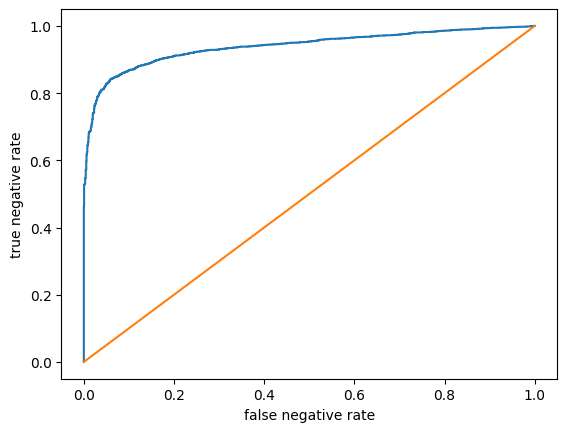

In [ ]:
plt.plot(fpr_neg, tpr_neg)
plt.plot(fpr_triv,tpr_triv)
plt.xlabel('false negative rate')
plt.ylabel('true negative rate')
plt.show()

(why is the roc curve for trivial classifier same as for a random classifier?)

In [ ]:
auc_score = roc_auc_score(y_test, y_prob[:,1])
print('auc = ', auc_score)

# auc_score_neg = roc_auc_score((np.ones(np.shape(y_test))-y_test), y_prob[:,0])
# print('negative auc score = ', auc_score_neg)

auc =  0.9385390196295069


AUC score of 0.68; quite poor

Best parameters for a 3-layer MLP: AUC score = 0.94; very good

### [(b) Use PUL file (60/40) + `train_df` for training:]

In [ ]:
train_ind = np.zeros(PUL_df.shape[0])
train_ind[:int(np.floor(PUL_df.shape[0]*0.6))] = 1 #prop. train
np.random.shuffle(train_ind)

X_PUL, y_PUL = PUL_df.to_numpy()[:,:-1], PUL_df.to_numpy()[:,-1:]

X_PUL_train, y_PUL_train = X_PUL[train_ind==1,:], y_PUL[train_ind==1]
X_PUL_test, y_PUL_test = X_PUL[train_ind==0,:], y_PUL[train_ind==0,:]

In [ ]:
X1_train, y1_train = np.concatenate([np.array(train_df.iloc[:,:-1]), X_PUL_train]), np.concatenate([np.array(train_df.iloc[:,-1:]), y_PUL_train])
X1_test, y1_test = X_PUL_test, y_PUL_test

In [ ]:
mlp1 = MLPClassifier(hidden_layer_sizes=(10,10,10),
                    activation = 'relu',
                    solver = 'adam',
                    verbose = True).fit(X1_train,y1_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55924477
Iteration 2, loss = 0.29139208
Iteration 3, loss = 0.22117616
Iteration 4, loss = 0.20915026
Iteration 5, loss = 0.20070854
Iteration 6, loss = 0.19331638
Iteration 7, loss = 0.18711276
Iteration 8, loss = 0.18265605
Iteration 9, loss = 0.17920480
Iteration 10, loss = 0.17504394
Iteration 11, loss = 0.17313134
Iteration 12, loss = 0.16985304
Iteration 13, loss = 0.16765605
Iteration 14, loss = 0.16487077
Iteration 15, loss = 0.16344621
Iteration 16, loss = 0.16196618
Iteration 17, loss = 0.16021931
Iteration 18, loss = 0.15801320
Iteration 19, loss = 0.15618093
Iteration 20, loss = 0.15528583
Iteration 21, loss = 0.15392939
Iteration 22, loss = 0.15088660
Iteration 23, loss = 0.14992218
Iteration 24, loss = 0.14986731
Iteration 25, loss = 0.14754133
Iteration 26, loss = 0.14511670
Iteration 27, loss = 0.14479812
Iteration 28, loss = 0.14488288
Iteration 29, loss = 0.14122364
Iteration 30, loss = 0.14026534
Iteration 31, loss = 0.13930781
Iteration 32, los

In [ ]:
y1_pred = mlp1.predict(X1_test)

NameError: name 'mlp1' is not defined

In [ ]:
print(accuracy_score(y1_test,y1_pred))
#confusion matrix
mat = confusion_matrix(y1_test, y1_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

0.7412337662337662
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             1938          461
Cazyme                  336          345


**1 layer:**

- 66.4% accuracy; still much worse than trivial classifier

- Positive prediction really poor

**2 layers:** (100,100)

- Relu: 73.6%

**3 layers:** (100,100,100)

- Relu: 76.7% , poor positive prediction (<50%)

**4:**
- Relu: 75.2%, poor positive prediction (50%)

### (c) Only use PUL file for training and testing: (60/40)

In [ ]:
X2_train, y2_train = X_PUL_train, y_PUL_train
X2_test, y2_test = X_PUL_test, y_PUL_test

In [ ]:
mlp2 = MLPClassifier(hidden_layer_sizes=(100,100),
                    activation = 'relu',
                    solver = 'adam',
                    verbose = True).fit(X2_train,y2_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55567637
Iteration 2, loss = 0.48351977
Iteration 3, loss = 0.46832773
Iteration 4, loss = 0.46029756
Iteration 5, loss = 0.45292093
Iteration 6, loss = 0.44632938
Iteration 7, loss = 0.43771742
Iteration 8, loss = 0.43126449
Iteration 9, loss = 0.42326714
Iteration 10, loss = 0.41405291
Iteration 11, loss = 0.40557543
Iteration 12, loss = 0.39433457
Iteration 13, loss = 0.38140771
Iteration 14, loss = 0.37806976
Iteration 15, loss = 0.36222290
Iteration 16, loss = 0.34947108
Iteration 17, loss = 0.33497619
Iteration 18, loss = 0.33345877
Iteration 19, loss = 0.31490704
Iteration 20, loss = 0.30467610
Iteration 21, loss = 0.29570629
Iteration 22, loss = 0.29469141
Iteration 23, loss = 0.28360093
Iteration 24, loss = 0.26760903
Iteration 25, loss = 0.25455942
Iteration 26, loss = 0.25855992
Iteration 27, loss = 0.24419306
Iteration 28, loss = 0.23548279
Iteration 29, loss = 0.23478562
Iteration 30, loss = 0.22276626
Iteration 31, loss = 0.21173582
Iteration 32, los

In [ ]:
y2_pred = mlp2.predict(X2_test)

In [ ]:
print(accuracy_score(y2_test,y2_pred))
mat = confusion_matrix(y2_test, y2_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

0.7707792207792208
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             2048          351
Cazyme                  355          326


- 1 layer (10 neurons): 80.7% accuracy, 

- 2 layers: 78.3% accuracy (100,100); 78.7% (10,10)
- poor positive prediction

- 3 layers: 79.7% (100,100,100); 78.2% (10,10,10) 

- 4 layers: 77.0% (10,10,10,10)



Fewer neurons lead to poorer positive prediction (why?)
- (10,10): 35.4%
- (3,3): 30.4%

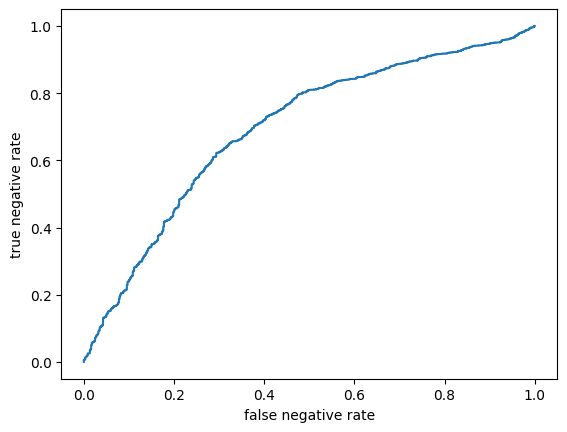

In [ ]:
y2_prob = mlp.predict_proba(X2_test)
fpr2, tpr2, thresholds2 = roc_curve(y2_test, y2_prob[:,0], pos_label=0)
plt.plot(fpr2, tpr2)
plt.xlabel('false negative rate')
plt.ylabel('true negative rate')
plt.show()

In [ ]:
auc2_score = roc_auc_score(y2_test, y2_prob[:,1])
print('auc = ', auc2_score)

auc =  0.694573852663769


AUC score = 0.69; not much better than in (a)